# Cuboid Rotation and translation to origin

In order to get the rotation for the input point cloud right (or should I say the bounding box of it), we will start with a regular cuboid, which is located somewhere in the global coordination system. The end goal is to translate it to the origin and rotate it, so that the left bottom point sits at the origin and the top right point of the same face of the cuboid, both sit in the the same plane created by the axes. Therefore, the plan is first to translate it to the origing and then rotate it 3 times around the respective coordinate axes and then possibly translate it so the bottom left point sits in at the origin. 

## Imports and needed functions

In [59]:
# For paths
import os 

# For data processing
import torch
import numpy as np
from torch.utils.data import Dataset
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

# Setting the root for this repo
ROOT = os.path.realpath("..")

# Creating/ Making the point cloud
def makePC(point_data, color_data=np.array([])):
    pcd = o3d.geometry.PointCloud() #Create PC object
    pcd.points = o3d.utility.Vector3dVector(point_data) #Give coordinates
    #Coloring the PC
    if len(color_data) == 0:
        pcd.paint_uniform_color([1, 0, 0])
    else:
        pcd.colors = o3d.utility.Vector3dVector(color_data)
    return pcd

# Axis alignment of given point cloud
def axisAlignment(main_pcd):
    """Rotating/axis aligning the pointcloud
    input: main_pcd = initial pointcloud (open3d.geometry.PointCloud object)
    output: main_pcd = rotated pointcloud (open3d.geometry.PointCloud object)"""
    bbox = main_pcd.get_oriented_bounding_box()
    inverse_R = np.linalg.inv(bbox.R)
    main_pcd.rotate(inverse_R)
    return main_pcd

def align_with_axes(bounding_box):
    u, s, vh = np.linalg.svd(bounding_box)
    rotation_matrix = vh.T @ u.T
    aligned_bounding_box = bounding_box @ rotation_matrix
    return aligned_bounding_box, rotation_matrix

## Creating Data

In [50]:
# Parameters for data creation
num_samples = 30
x_y_sequence_to_sample_from = np.linspace(10, 50, 100).tolist()
z_sequence_to_sample_from = np.linspace(20, 35, 50).tolist()

# Randomly sampling values for coords
x_coords = np.array(random.sample(x_y_sequence_to_sample_from, num_samples))
y_coords = np.array(random.sample(x_y_sequence_to_sample_from, num_samples))
z_coords = np.array(random.sample(z_sequence_to_sample_from, num_samples))
point_coords = np.concatenate([x_coords.reshape(-1,1), 
                               y_coords.reshape(-1,1), 
                               z_coords.reshape(-1,1)], 
                               axis=1)

# Creating color arrya for created points (blue)
point_colors = np.concatenate([np.zeros(num_samples).reshape(-1,1), 
                               np.zeros(num_samples).reshape(-1,1), 
                               np.ones(num_samples).reshape(-1,1)], 
                               axis=1)



## Visualization of created data

In [51]:
# Create PC
points_pc = makePC(point_coords, point_colors)

# Draw PC
#o3d.visualization.draw(points_pc, point_size=5)

## Visualization of created data with axes

In [52]:
# Sampling parameters
axes_num_points = 1000
axes_val_limit = 60
axes_val_range = np.array(np.linspace(-axes_val_limit, axes_val_limit, axes_num_points))

# Creating axes point coordinates
x_axis = np.stack([axes_val_range, np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1)
y_axis = np.stack([np.zeros(axes_num_points), axes_val_range, np.zeros(axes_num_points)], axis=1)
z_axis = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), axes_val_range], axis=1)
axes_points = np.concatenate([x_axis, y_axis, z_axis], axis=0) 
x_axis_color = np.stack([np.ones(axes_num_points), np.zeros(axes_num_points), np.zeros(axes_num_points)], axis=1) #RED
y_axis_color = np.stack([np.zeros(axes_num_points), np.ones(axes_num_points), np.zeros(axes_num_points)], axis=1) #GREEN
z_axis_color = np.stack([np.zeros(axes_num_points), np.zeros(axes_num_points), np.ones(axes_num_points)], axis=1) #BLUE
axes_colors = np.concatenate([x_axis_color, y_axis_color, z_axis_color], axis=0)

# Make point cloud for axes
axes_pc = makePC(axes_points, axes_colors)

# Draw PC's
#o3d.visualization.draw([points_pc, axes_pc], point_size=5)


## Visualization of created data with axes and bounding box

In [53]:
# Bounding box creation
bbox = points_pc.get_oriented_bounding_box()
bbox.color = (0, 0, 1)

# Drawing 
o3d.visualization.draw([points_pc, axes_pc, bbox], point_size=5)

## Translating created data to the origin

In [56]:
# Retrieve center of input points pc
points_pc_center = points_pc.get_center()

# Shifting center of pc to origin 
shifted_pc_coords = np.array(points_pc.points) - points_pc_center

# Creating color array for shifted pc
shifted_points_color =  np.concatenate([np.ones(num_samples).reshape(-1,1),
                                        np.zeros(num_samples).reshape(-1,1), 
                                        np.zeros(num_samples).reshape(-1,1)], 
                                        axis=1)

# Creating the shifted/ translated pc
shifted_pc = makePC(shifted_pc_coords, shifted_points_color)
shifted_pc_bbox = shifted_pc.get_oriented_bounding_box()
shifted_pc_bbox.color = (1, 0, 0) #RED

o3d.visualization.draw([points_pc, shifted_pc, axes_pc, bbox, shifted_pc_bbox], point_size=5)

## Bounding Box Rotation

In [87]:
'''
Lukaš send me this idea for figuring out and rotating a cuboid with the help of single value decomposition.
But it seems to only work if the input is 3 (orthogonal vectors)
'''
def align_with_axes(bounding_box):
    u, s, vh = np.linalg.svd(bounding_box)
    rotation_matrix = vh.T @ u.T
    aligned_bounding_box = bounding_box @ rotation_matrix
    return aligned_bounding_box, rotation_matrix

## Determining the orthogonal vector trio of the bounding box corner 

In [76]:
# Picking the "lowest" (in z-direction) point as a corner
shifted_pc_bbox_points = np.array(shifted_pc_bbox.get_box_points())
shifted_bbox_corners = np.array(shifted_pc_bbox.get_box_points())
z_value_lowest_corner = np.min(shifted_bbox_corners[:, 2])
lowest_corner_idx = int(np.where(shifted_bbox_corners == z_value_lowest_corner)[0])
lowest_corner_coords = shifted_bbox_corners[lowest_corner_idx]

# Construct vectors to all points
lowest_corner_to_corner_vectors = []
#TODO: Think about the iteration with reespect top the picked point -> 7 edges
for i in range(len(shifted_bbox_corners)):
    lowest_corner_to_corner_vector = shifted_bbox_corners[i] - lowest_corner_coords
    if (lowest_corner_to_corner_vector == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors.append(lowest_corner_to_corner_vector)
    # should have 7 vectors
# Determining the distances of all the vectors
vector_distances = []
for i in range(len(lowest_corner_to_corner_vectors)):
    vec_i_distance = np.linalg.norm(lowest_corner_to_corner_vectors[i])
    vector_distances.append(vec_i_distance)
    # Should have 7 distances
# Picking shortest distance
shortest_lowest_corner_to_corner_vector = np.min(vector_distances)
shortest_lowest_corner_to_corner_vector_idx = int(
    np.where(vector_distances == shortest_lowest_corner_to_corner_vector)[0]
    )
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_lowest_corner_to_corner_vector_idx]
#TODO: Check whether the three shortest are always the orthogoanl ones, but sounds unlikely
# Calculating the cross product to check for angle with shortest vector
orthogonal_corner_vectors = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product = np.dot(
        shortest_lowest_corner_to_corner_vector_coords, 
        lowest_corner_to_corner_vectors[i]
        )
    if dot_product <= 0.001:
        orthogonal_corner_vectors.append(lowest_corner_to_corner_vectors[i])
    # Should have three vectors
print("Rotation is fun!")

/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_45763/1984845325.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lowest_corner_idx = int(np.where(shifted_bbox_corners == z_value_lowest_corner)[0])


/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_45763/1984845325.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_lowest_corner_to_corner_vector_idx = int(


Rotation is fun!


Trying the function

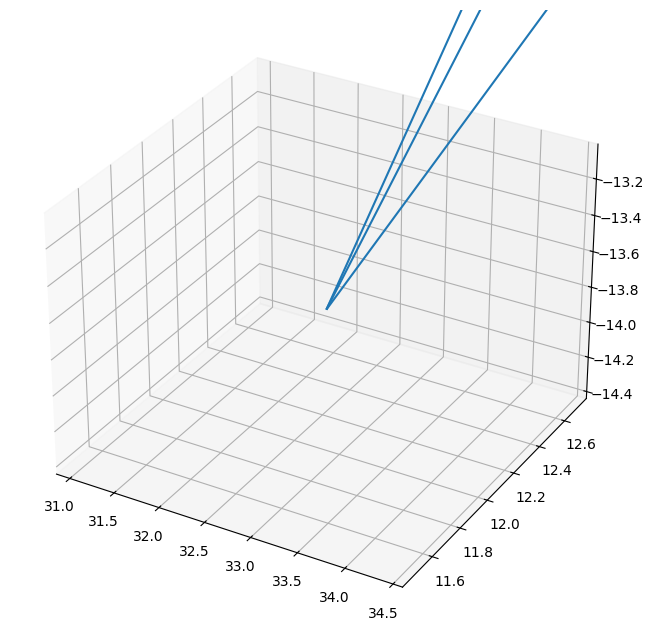

In [89]:
aligned_cuboid, rotation_matrix = align_with_axes(orthogonal_corner_vectors)

# Instantiting new figure to plot in
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

# arrow positions -> should all be in the same position og lowest corner
quivers_x_y = np.array([[lowest_corner_coords] * len(orthogonal_corner_vectors)])

# Preparing data for quiver display
X = quivers_x_y[:,:,0]
Y = quivers_x_y[:,:,1]
Z = quivers_x_y[:,:,2]
U = np.array(aligned_cuboid)[:,0]
V = np.array(aligned_cuboid)[:,1]
W = np.array(aligned_cuboid)[:,2]

# Plotting
ax.quiver(X, Y, Z, U, V, W, length=0.2)

plt.show()

Visalization of the determing orthogonal vectors

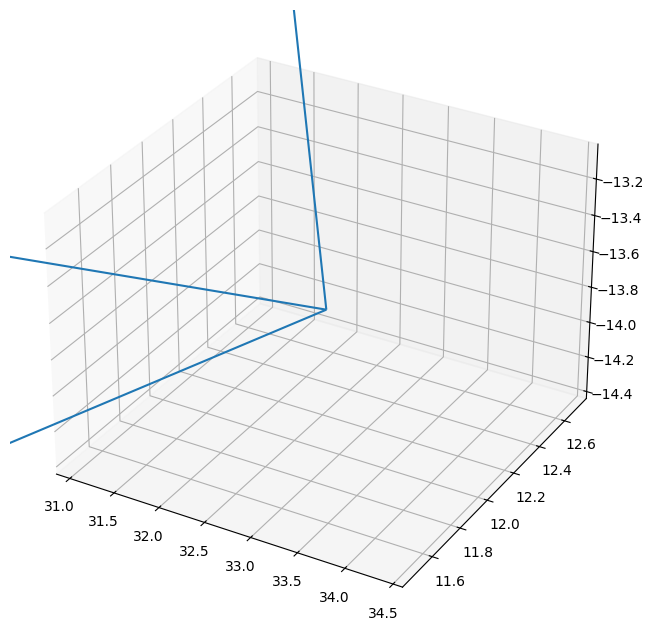

In [90]:
# Instantiting new figure to plot in
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

# arrow positions -> should all be in the same position og lowest corner
quivers_x_y = np.array([[lowest_corner_coords] * len(orthogonal_corner_vectors)])

# Preparing data for quiver display
X = quivers_x_y[:,:,0]
Y = quivers_x_y[:,:,1]
Z = quivers_x_y[:,:,2]
U = np.array(orthogonal_corner_vectors)[:,0]
V = np.array(orthogonal_corner_vectors)[:,1]
W = np.array(orthogonal_corner_vectors)[:,2]

# Plotting
ax.quiver(X, Y, Z, U, V, W, length=0.2)

plt.show()

## Test with handrafted translated and rotated cuboid

In [145]:
# Create cuboid
cuboid_coords = np.array([
    [-4, 2, 0], 
    [4, 2, 0],
    [4, -2, 0],
    [-4, -2, 0],
    [4, 2, 1], 
    [4, -2, 1],
    [-4, -2, 1], 
    [-4, 2, 1]
])

# Rotattion matrix creation
theta1, theta2, theta3 = 15, 25, 20
cos1, sin1 = np.cos(theta1), np.sin(theta1)
cos2, sin2 = np.cos(theta2), np.sin(theta2)
cos3, sin3 = np.cos(theta3), np.sin(theta3)
Rx = [[1,   0,      0    ],
      [0,   cos1,   -sin1], 
      [0,   sin1,   cos1 ]]
Ry = [[cos2,    0,  sin2],
      [0,       1,  0   ], 
      [-sin2,   0,  cos2]]
Rz =[[cos3, -sin3,  0   ], 
     [sin3, cos3,   0   ],
     [0,    0,      1   ]]

# Rotation of the cuboid coords
rotated_cuboid_coords_list = []
for i in range(len(cuboid_coords)):
    x_rotated_cuboid_point_coords = cuboid_coords[i].T @ Rx
    xy_rotated_cuboid_point_coords = x_rotated_cuboid_point_coords @ Ry
    xyz_rotated_cuboid_point_coords = xy_rotated_cuboid_point_coords @ Rz
    rotated_cuboid_coords_list.append(xyz_rotated_cuboid_point_coords)
# Conmversion to array
rotated_cuboid_coords = np.array(rotated_cuboid_coords_list)


# Translate Cuboid
translation_vec = np.array([2, 4, 5])
translated_rotated_cuboid_coords = np.array(rotated_cuboid_coords) + translation_vec

## Visualization of original points, rotated points and rotated and translated points

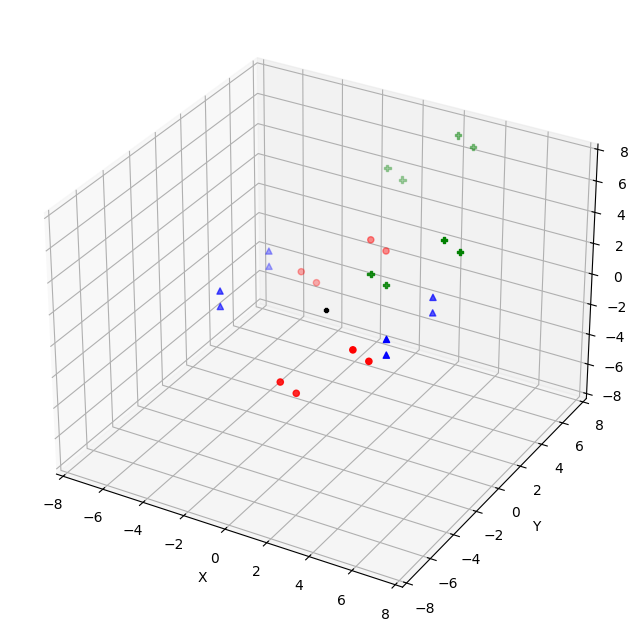

In [148]:
# Visualize the points to check if it worked
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Origin
ax.scatter(xs=0,
           ys=0,
           zs=0,
           marker='P', 
           c='black', 
           s=5)

# First cuboid points (blue)
ax.scatter(xs=cuboid_coords[:,0],
           ys=cuboid_coords[:,1],
           zs=cuboid_coords[:,2],
           marker='^', 
           c='blue')
# Rotated cuboid points (red)
ax.scatter(xs=rotated_cuboid_coords[:,0],
           ys=rotated_cuboid_coords[:,1],
           zs=rotated_cuboid_coords[:,2],
           marker='o', 
           c='red')
# Rotated and translated cuboid points (green)
ax.scatter(xs=translated_rotated_cuboid_coords[:,0],
           ys=translated_rotated_cuboid_coords[:,1],
           zs=translated_rotated_cuboid_coords[:,2],
           marker='P', 
           c='green')

plt.show()

## Determining orthogonal vector trio of arbitrary point

In [139]:
# Picking the "lowest" (in z-direction) point as a corner
z_value_lowest_corner = np.min(translated_rotated_cuboid_coords[:, 2])
lowest_corner_idx = int(np.where(translated_rotated_cuboid_coords == z_value_lowest_corner)[0])
lowest_corner_coords = translated_rotated_cuboid_coords[lowest_corner_idx]

# Construct vectors from lowest point to all other points
lowest_corner_to_corner_vectors = []
for i in range(len(translated_rotated_cuboid_coords)):
    lowest_corner_to_corner_vector = translated_rotated_cuboid_coords[i] - lowest_corner_coords
    if (lowest_corner_to_corner_vector == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors.append(lowest_corner_to_corner_vector)

# Determining the distances of all the vectors
vector_distances = []
for i in range(len(lowest_corner_to_corner_vectors)):
    vec_i_distance = np.linalg.norm(lowest_corner_to_corner_vectors[i])
    vector_distances.append(vec_i_distance)
# Picking shortest distance
shortest_lowest_corner_to_corner_vector = np.min(vector_distances)
shortest_lowest_corner_to_corner_vector_idx = int(
    np.where(vector_distances == shortest_lowest_corner_to_corner_vector)[0]
    )
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_lowest_corner_to_corner_vector_idx]

# Calculating the cross product to check for angle with shortest vector
orthogonal_corner_vectors_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product = np.dot(
        shortest_lowest_corner_to_corner_vector_coords, 
        lowest_corner_to_corner_vectors[i]
        )
    if dot_product <= 0.0001:
        orthogonal_corner_vectors_list.append(lowest_corner_to_corner_vectors[i])
    # Should have three vectors

/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_45763/1483947406.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lowest_corner_idx = int(np.where(translated_rotated_cuboid_coords == z_value_lowest_corner)[0])
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_45763/1483947406.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_lowest_corner_to_corner_vector_idx = int(


## Visualizing the orthogonal vectors

In [ ]:
# Instantiting new figure to plot in
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')



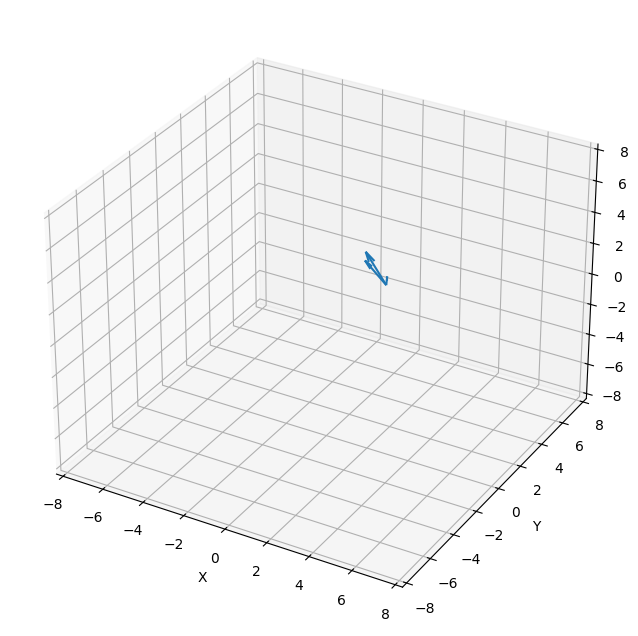

In [150]:
# Instantiting new figure to plot in
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')

# arrow positions -> should all be in the same position og lowest corner
quivers_x_y = np.array([[lowest_corner_coords] * len(orthogonal_corner_vectors)])

# Preparing data for quiver display
X = quivers_x_y[:,:,0]
Y = quivers_x_y[:,:,1]
Z = quivers_x_y[:,:,2]
U = np.array(orthogonal_corner_vectors)[:,0]
V = np.array(orthogonal_corner_vectors)[:,1]
W = np.array(orthogonal_corner_vectors)[:,2]

ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plotting
ax.quiver(X, Y, Z, U, V, W, length=0.2)

plt.show()

## Determining the angles between axes and orthogonal vector trio

In [ ]:
# Defining shortest distance as y
# Defining angle to y axis
# Rotate

# Second longest as z
# New rotation angle around z
# Rotate around z

# longest as x
# new rotation angle around x
# Rotate around x for final position


## Visualization of rotated and translated points

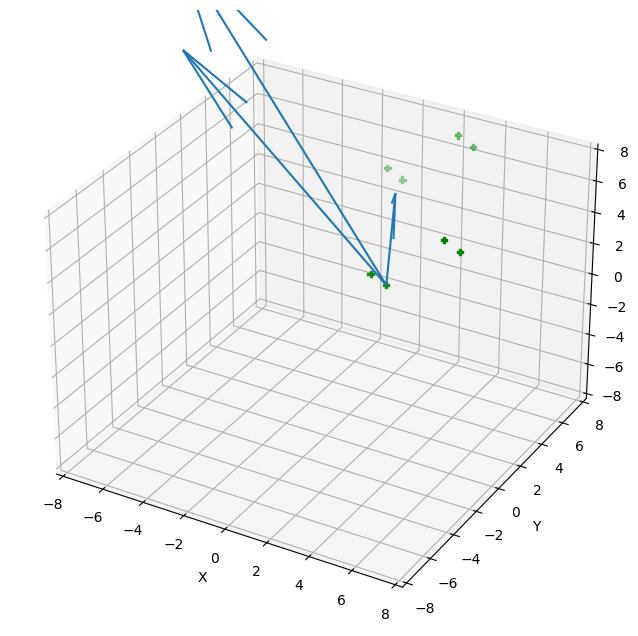

: 

In [152]:
# Visualize the points to check if it worked
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])
ax.set_zlim([-8, 8])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Translated and rotated cuboid points (green +)
ax.scatter(xs=translated_rotated_cuboid_coords[:,0],
           ys=translated_rotated_cuboid_coords[:,1],
           zs=translated_rotated_cuboid_coords[:,2],
           marker='P', 
           c='green')

# arrow positions -> should all be in the same position og lowest corner
quivers_x_y = np.array([[lowest_corner_coords] * len(orthogonal_corner_vectors)])

# Preparing data for quiver display
X = quivers_x_y[:,:,0]
Y = quivers_x_y[:,:,1]
Z = quivers_x_y[:,:,2]
U = np.array(orthogonal_corner_vectors)[:,0]
V = np.array(orthogonal_corner_vectors)[:,1]
W = np.array(orthogonal_corner_vectors)[:,2]

ax.quiver(X, Y, Z, U, V, W, length=2)

plt.show()

## Testing rotation via SVD

In [141]:
def align_with_axes(bounding_box):
    u, s, vh = np.linalg.svd(bounding_box)
    rotation_matrix = vh.T @ u.T
    aligned_bounding_box = bounding_box @ rotation_matrix
    return aligned_bounding_box, rotation_matrix

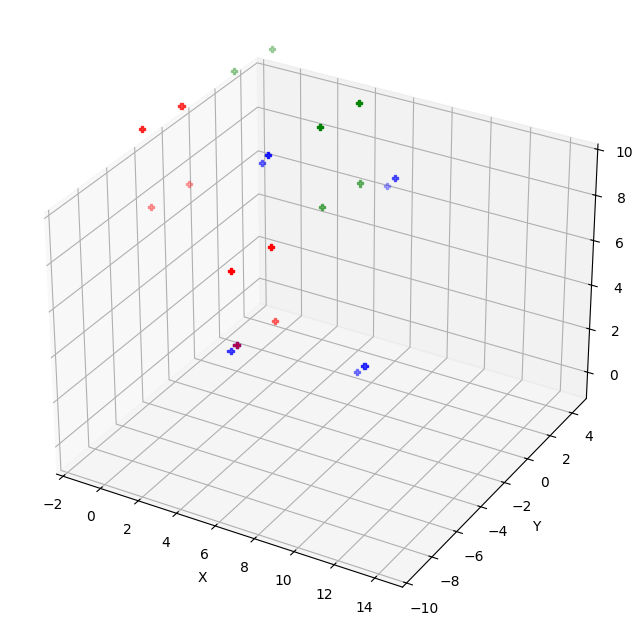

In [132]:
orthogonal_corner_vectors = np.array(orthogonal_corner_vectors_list)
not_relevant, rotation_matrix = align_with_axes(orthogonal_corner_vectors)

# Applying rotation matrix to the original vectors
backtranslated_rotated_cuboid_coords = translated_rotated_cuboid_coords - translation_vec
aligned_backtranslated_rotated_cuboid_coords = backtranslated_rotated_cuboid_coords @ rotation_matrix

# Visualize the points to check if it worked
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-2, 15])
ax.set_ylim([-10, 5])
ax.set_zlim([-1, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Translated and rotated
ax.scatter(xs=translated_rotated_cuboid_coords[:,0],
           ys=translated_rotated_cuboid_coords[:,1],
           zs=translated_rotated_cuboid_coords[:,2],
           marker='P', 
           c='green')

# Aligned
ax.scatter(xs=backtranslated_rotated_cuboid_coords[:,0],
           ys=backtranslated_rotated_cuboid_coords[:,1],
           zs=backtranslated_rotated_cuboid_coords[:,2],
           marker='P', 
           c='red')

# Translated back
ax.scatter(xs=aligned_backtranslated_rotated_cuboid_coords[:,0],
           ys=aligned_backtranslated_rotated_cuboid_coords[:,1],
           zs=aligned_backtranslated_rotated_cuboid_coords[:,2],
           marker='P', 
           c='blue')

plt.show()

In [ ]:
# translate back


In [133]:
orthogonal_corner_vectors, rotation_matrix = np.array(orthogonal_corner_vectors_list)
aligned_orthogonal_corner_vectors = align_with_axes(orthogonal_corner_vectors)

# Display of misaligned and aligned corner vectors
fig = plt.figure()

ax = fig.add_subplot(121, projection='3d')
ax.set_title('Misaligned Cuboid')
ax.set_xlim([-1, 3])
ax.set_ylim([-1, 3])
ax.set_zlim([-1, 3])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
R = np.eye(3)
ax.quiver(0, 0, 0, R[0, 0], R[1, 0], R[2, 0], color='r')
ax.quiver(0, 0, 0, R[0, 1], R[1, 1], R[2, 1], color='g')
ax.quiver(0, 0, 0, R[0, 2], R[1, 2], R[2, 2], color='b')
ax.plot([0, orthogonal_corner_vectors[0, 0]], 
        [0, orthogonal_corner_vectors[1, 0]], 
        [0, orthogonal_corner_vectors[2, 0]], 
        color='r')
ax.plot([0, orthogonal_corner_vectors[0, 1]], 
        [0, orthogonal_corner_vectors[1, 1]], 
        [0, orthogonal_corner_vectors[2, 1]], 
        color='g')
ax.plot([0, orthogonal_corner_vectors[0, 2]], 
        [0, orthogonal_corner_vectors[1, 2]], 
        [0, orthogonal_corner_vectors[2, 2]], 
        color='b')

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Aligned Cuboid')
ax.set_xlim([-1, 3])
ax.set_ylim([-1, 3])
ax.set_zlim([-1, 3])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
R = np.eye(3)
ax.quiver(0, 0, 0, R[0, 0], R[1, 0], R[2, 0], color='r')
ax.quiver(0, 0, 0, R[0, 1], R[1, 1], R[2, 1], color='g')
ax.quiver(0, 0, 0, R[0, 2], R[1, 2], R[2, 2], color='b')
ax.plot([0, aligned_cuboid[0, 0]], [0, aligned_cuboid[1, 0]], [0, aligned_cuboid[2, 0]], color='r')
ax.plot([0, aligned_cuboid[0, 1]], [0, aligned_cuboid[1, 1]], [0, aligned_cuboid[2, 1]], color='g')
ax.plot([0, aligned_cuboid[0, 2]], [0, aligned_cuboid[1, 2]], [0, aligned_cuboid[2, 2]], color='b')

plt.show()


ValueError: too many values to unpack (expected 2)